In [1]:
#%%capture
!pip install nltk

In [2]:
# General packages
!pip install wordcloud

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# NLP packages
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from wordcloud import WordCloud
nltk.download('punkt')

# Modeling packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB 
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from pylab import rcParams
import warnings
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 14, 6
plt.style.use('ggplot')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
from google.colab import files
uploaded = files.upload()


Saving Customer_Reviews.csv to Customer_Reviews.csv


In [4]:
import io
customer_reviews = pd.read_csv(io.BytesIO(uploaded['Customer_Reviews.csv']))
#customer_reviews = pd.read_csv('./Customer_Reviews.csv')
customer_reviews.head(3)
# Dataset is now stored in a Pandas Dataframe


,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


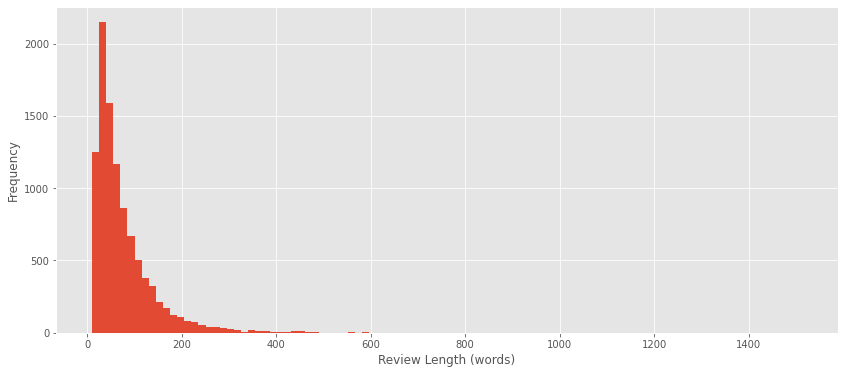

In [5]:
## Getting the number of words by splitting them by a space
words_per_review = customer_reviews.Text.apply(lambda x: len(x.split(" ")))
#new_df = df.apply(lambda x : len(x.split(" ")))
words_per_review.hist(bins = 100)
plt.xlabel('Review Length (words)')
plt.ylabel('Frequency')
plt.show()

In [6]:
print('Average words:', words_per_review.mean())
print('Skewness:', words_per_review.skew())

Average words: 77.9028
Skewness: 4.612459483340116


Words per user review is highly skewed with mean of 77, which means that on average, user reviews have 77 words.

In [7]:
percent_val = 100 * customer_reviews['Score'].value_counts()/len(customer_reviews)
percent_val

5    61.83
4    14.33
1     9.32
3     8.62
2     5.90
Name: Score, dtype: float64

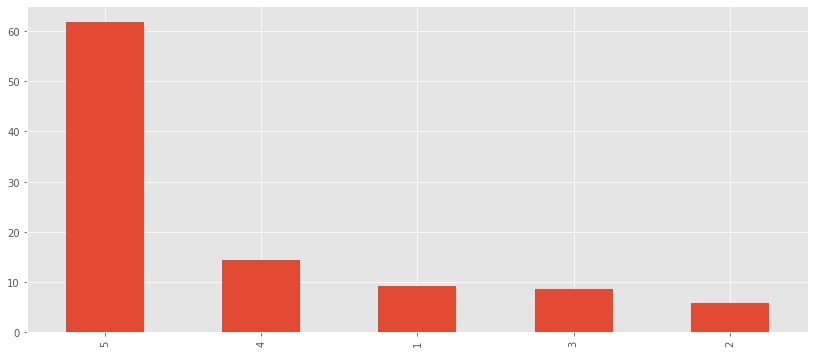

In [8]:
percent_val.plot.bar()
plt.show()

The distribution is quite skewed, with a giant number of 5s and very few 3s, 2s, and 1s. As seen, there is a class imbalance.

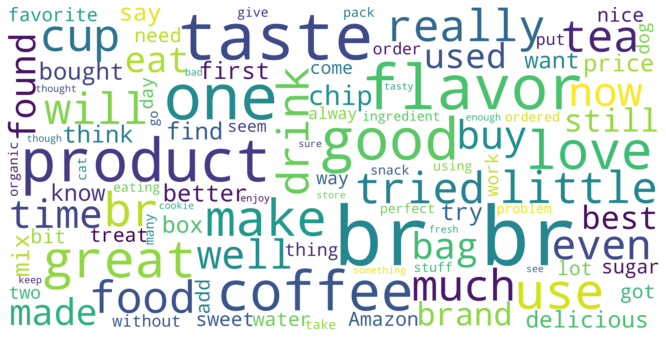

In [9]:
word_cloud_text = ''.join(customer_reviews['Text'])

wordcloud = WordCloud(max_font_size=100, # Maximum font size for the largest word
                      max_words=100, # The maximum number of words
                      background_color="white", # Background color for the word cloud image
                      scale = 10, # Scaling between computation and drawing
                      width=800, # Width of the canvas
                      height=400 # Height of the canvas
                     ).generate(word_cloud_text)

plt.figure()
plt.imshow(wordcloud, 
           interpolation="bilinear") # to make the displayed image appear more smoothly
plt.axis("off")
plt.show()

The word cloud indicates that many of the reviews talk about food-related things - coffee, flavor, food, taste, drink. We also see some positive words like great,good, love, best.

#Applying oversampling techniques to deal with data imbalance.

In [10]:
from sklearn.utils import resample
# separate minority and majority classes
Rating_5       = customer_reviews[customer_reviews.Score==5]
Rating_4       = customer_reviews[customer_reviews.Score==4]
Rating_3       = customer_reviews[customer_reviews.Score==3]
Rating_2       = customer_reviews[customer_reviews.Score==2]
Rating_1       = customer_reviews[customer_reviews.Score==1]


list_Score=[Rating_1, Rating_2, Rating_3,Rating_4, Rating_5]
# Get a class count to understand the class imbalance.
for i in range(0,5):
    print('Score:{} - score count: '.format(i+1) + str(len(list_Score[i])))

Score:1 - score count: 932
Score:2 - score count: 590
Score:3 - score count: 862
Score:4 - score count: 1433
Score:5 - score count: 6183


In [11]:
# upsample minority
def upsample(minority):
    df= resample(minority,replace=True, n_samples=len(Rating_5), random_state=23) # reproducible results
    return df

 
# using the upsample function to obtain upsampled data
upsampled_1=upsample(Rating_1)
upsampled_2=upsample(Rating_2)
upsampled_3=upsample(Rating_3)
upsampled_4=upsample(Rating_4)


In [12]:
# combine majority and upsampled minority
upsampled= pd.concat([upsampled_1,upsampled_2, upsampled_3, upsampled_4, Rating_5])
# check new class counts
upsampled.Score.value_counts()

5    6183
4    6183
3    6183
2    6183
1    6183
Name: Score, dtype: int64

For the purposes of sentiment analysis:
- Ratings of 4 or 5 will get mapped to 1 and will be related to positive reviews
- Ratings of 1 or 2 will get mapped to 0 and will be related to negative reviews
- Ratings of 3 will get removed since they will represent neutral reviews.

In [13]:
# Mapping the ratings
#customer_reviews['Sentiment_rating'] = np.where(customer_reviews.Score > 3,1,0)
#customer_reviews['Sentiment_rating'].value_counts()
upsampled['Sentiment_rating'] = np.where(upsampled.Score > 3,1,0)
upsampled['Sentiment_rating'].value_counts()

## Removing neutral reviews 
upsampled = upsampled[upsampled.Score != 3]

# Printing the counts of each class
upsampled['Sentiment_rating'].value_counts()

1    12366
0    12366
Name: Sentiment_rating, dtype: int64

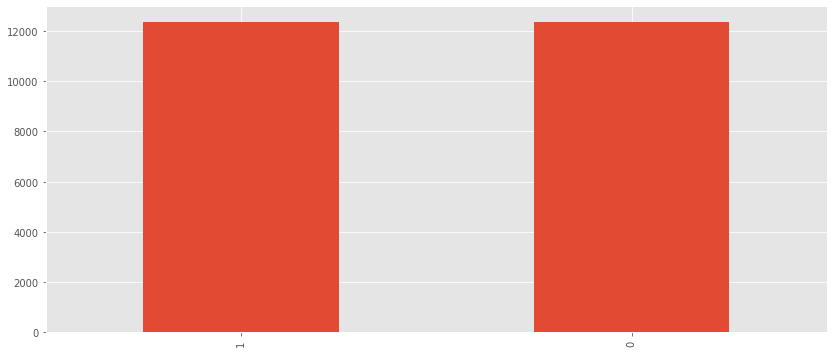

In [14]:
upsampled.Sentiment_rating.value_counts().plot.bar()
plt.show()

Both classes are now balanced as seen.

#Pre-processing

1. Converting words to lower/upper case
2. Removing special characters
3. Removing stopwords and high/low-frequency words
4. Stemming/lemmatization



In [15]:
#1. Converting words to lower case
upsampled['reviews_text_new'] = upsampled['Text'].str.lower()

In [16]:
from nltk import word_tokenize
# For reviews not converted to lower case
token_lists = [word_tokenize(each) for each in upsampled['Text']]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens then: ",len(set(tokens)))

# For reviews converted to lower case
token_lists_lower = [word_tokenize(each) for each in upsampled['reviews_text_new']]
tokens_lower = [item for sublist in token_lists_lower for item in sublist]
print("Number of unique tokens now: ",len(set(tokens_lower)))

Number of unique tokens then:  27876
Number of unique tokens now:  22849


The number of tokens has gone down by ~18% just from normalizing the corpus.

### 2. Removing special characters

In [17]:

### Selecting non alpha numeric charactes that are not spaces
spl_chars = upsampled['reviews_text_new'].apply(lambda review: 
                                                     [char for char in list(review) if not char.isalnum() and char != ' '])

## Getting list of list into a single list
flat_list = [item for sublist in spl_chars for item in sublist]

## Unique special characters
set(flat_list)


{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 ']',
 '^',
 '_',
 '`',
 '{',
 '}',
 '~',
 '§',
 '®'}

Remove these special characters from the reviews by applying a regular expression:

In [22]:
review_backup = upsampled['reviews_text_new'].copy()
upsampled['reviews_text_new'] = upsampled['reviews_text_new'].str.replace(r'[^A-Za-z0-9 ]+', ' ')


Decompose the regular expression `[^A-Za-z0-9 ]+`:
- `[ ]`: match any character inside the list defined by the square brackets, including the space character `' '`
- `^`: start of the line
- `A-Z`: accept english upper case characters from A to Z
- `a-z`: accept english lower case characters from a to z
- `0-9`: accept single number characters from 0 to 9 **bold text**

In [23]:
print("- Old Review -")
print(review_backup.values[6])
print("\n- New Review -")
print(upsampled['reviews_text_new'][6])

- Old Review -
this tea didn't do anything, steal have issues with itching throat, ear and everything else. but i do enjoy the smell of it.. ill say it last up to a few hours and that's it.

- New Review -
this saltwater taffy had great flavors and was very soft and chewy   each candy was individually wrapped well   none of the candies were stuck together  which did happen in the expensive version  fralinger s   would highly recommend this candy   i served it at a beach themed party and everyone loved it 


The number of unique tokens has dropped further:

In [24]:
token_lists = [word_tokenize(each) for each in upsampled['Text']]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens then: ",len(set(tokens)))

token_lists = [word_tokenize(each) for each in upsampled['reviews_text_new']]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens now: ",len(set(tokens)))

Number of unique tokens then:  27876
Number of unique tokens now:  18029


In [25]:
#3. Stopwords and high/low frequency words
from nltk.corpus import stopwords
nltk.download('stopwords')

print('Available languages for NLTK v.3.4.5: ')
print(stopwords.fileids())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Available languages for NLTK v.3.4.5: 
['arabic', 'azerbaijani', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'turkish']


In [26]:
# review the list of English stopwords:
noise_words = []
eng_stop_words = stopwords.words('english')
eng_stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [27]:
#removing stopwords:
stop_words = set(eng_stop_words)
without_stop_words = []
stopword = []
sentence = upsampled['reviews_text_new'][0]
words = nltk.word_tokenize(sentence)

for word in words:
    if word in stop_words:
        stopword.append(word)
    else:
        without_stop_words.append(word)

print('-- Original Sentence --\n', sentence)
print('\n-- Stopwords in the sentence --\n', stopword)
print('\n-- Non-stopwords in the sentence --\n', without_stop_words)

-- Original Sentence --
 i have bought several of the vitality canned dog food products and have found them all to be of good quality  the product looks more like a stew than a processed meat and it smells better  my labrador is finicky and she appreciates this product better than  most 

-- Stopwords in the sentence --
 ['i', 'have', 'of', 'the', 'and', 'have', 'them', 'all', 'to', 'be', 'of', 'the', 'more', 'a', 'than', 'a', 'and', 'it', 'my', 'is', 'and', 'she', 'this', 'than', 'most']

-- Non-stopwords in the sentence --
 ['bought', 'several', 'vitality', 'canned', 'dog', 'food', 'products', 'found', 'good', 'quality', 'product', 'looks', 'like', 'stew', 'processed', 'meat', 'smells', 'better', 'labrador', 'finicky', 'appreciates', 'product', 'better']


In [28]:
#omit these stopwords from our reviews:
def stopwords_removal(stop_words, sentence):
    return [word for word in nltk.word_tokenize(sentence) if word not in stop_words]

upsampled['reviews_text_nonstop'] = upsampled['reviews_text_new'].apply(lambda row: stopwords_removal(stop_words, row))
upsampled[['reviews_text_new','reviews_text_nonstop']]

,reviews_text_new,reviews_text_nonstop
6433,skittles are a great candy but for this produc...,"[skittles, great, candy, product, would, say, ..."
8139,i was very unhappy when this package arrived a...,"[unhappy, package, arrived, workplace, bags, w..."
537,when originally produced in england these we ...,"[originally, produced, england, best, chips, e..."
5093,first of all somebody is chasing me around a...,"[first, somebody, chasing, around, negging, re..."
393,i haven t used the ham base it is loaded with...,"[used, ham, base, loaded, msg, realize, ordere..."
...,...,...
9993,as far as i can tell this is the only organic...,"[far, tell, organic, ready, feed, formula, us,..."
9994,i switched from similac advanced to organic wh...,"[switched, similac, advanced, organic, daughte..."
9996,like the bad reviews say the organic formula ...,"[like, bad, reviews, say, organic, formula, co..."
9997,i wanted to solely breastfeed but was unable t...,"[wanted, solely, breastfeed, unable, keep, sup..."


In [29]:
from nltk.stem import PorterStemmer, LancasterStemmer # Common stemmers
from nltk.stem import WordNetLemmatizer # Common Lematizer
nltk.download('wordnet')
from nltk.corpus import wordnet

porter = PorterStemmer()
lancaster = LancasterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [30]:
print("Lancaster Stemmer")
print(lancaster.stem("trouble"))
print(lancaster.stem("troubling"))
print(lancaster.stem("troubled"))

# Provide a word to be lemmatized
print("WordNet Lemmatizer")
print(lemmatizer.lemmatize("trouble", wordnet.NOUN))
print(lemmatizer.lemmatize("troubling", wordnet.VERB))
print(lemmatizer.lemmatize("troubled", wordnet.VERB))

Lancaster Stemmer
troubl
troubl
troubl
WordNet Lemmatizer
trouble
trouble
trouble


In [31]:
def stemm_terms(row):
    return [lancaster.stem(term) for term in row]
def lemmatize_terms(row):
    return [lemmatizer.lemmatize(term) for term in row]
    
upsampled['reviews_text_stemm'] = upsampled['reviews_text_nonstop'].apply(lambda row: stemm_terms(row))
upsampled['reviews_text_lemm'] = upsampled['reviews_text_nonstop'].apply(lambda row: lemmatize_terms(row))
upsampled[['reviews_text_nonstop','reviews_text_stemm','reviews_text_lemm']]

,reviews_text_nonstop,reviews_text_stemm,reviews_text_lemm
6433,"[skittles, great, candy, product, would, say, ...","[skittl, gre, candy, produc, would, say, buy, ...","[skittle, great, candy, product, would, say, b..."
8139,"[unhappy, package, arrived, workplace, bags, w...","[unhappy, pack, ar, workplac, bag, wrap, ship,...","[unhappy, package, arrived, workplace, bag, wr..."
537,"[originally, produced, england, best, chips, e...","[origin, produc, england, best, chip, ev, tast...","[originally, produced, england, best, chip, ev..."
5093,"[first, somebody, chasing, around, negging, re...","[first, somebody, chas, around, neg, review, d...","[first, somebody, chasing, around, negging, re..."
393,"[used, ham, base, loaded, msg, realize, ordere...","[us, ham, bas, load, msg, real, ord, return, f...","[used, ham, base, loaded, msg, realize, ordere..."
...,...,...,...
9993,"[far, tell, organic, ready, feed, formula, us,...","[far, tel, org, ready, fee, formul, us, market...","[far, tell, organic, ready, feed, formula, u, ..."
9994,"[switched, similac, advanced, organic, daughte...","[switch, similac, adv, org, daught, 1, mon, ol...","[switched, similac, advanced, organic, daughte..."
9996,"[like, bad, reviews, say, organic, formula, co...","[lik, bad, review, say, org, formul, constip, ...","[like, bad, review, say, organic, formula, con..."
9997,"[wanted, solely, breastfeed, unable, keep, sup...","[want, sol, breastfee, un, keep, suppl, formul...","[wanted, solely, breastfeed, unable, keep, sup..."


The actual review text and its corresponding sentiment rating:

In [32]:
upsampled[['Text','Score','Sentiment_rating']].head(5)

,Text,Score,Sentiment_rating
6433,Skittles are a great candy but for this produc...,1,0
8139,I was very unhappy when this package arrived a...,1,0
537,When originally produced in England these we'...,1,0
5093,"(First of all, somebody is chasing me around a...",1,0
393,I haven't used the ham base. It is loaded with...,1,0


In [33]:
from nltk import ngrams

sentence = 'A bird in the hand worths two in the bush'

for n in range(1, 6):
    print(str(n) + '-grams:\n', list(ngrams(sentence.split(), n)))

1-grams:
 [('A',), ('bird',), ('in',), ('the',), ('hand',), ('worths',), ('two',), ('in',), ('the',), ('bush',)]
2-grams:
 [('A', 'bird'), ('bird', 'in'), ('in', 'the'), ('the', 'hand'), ('hand', 'worths'), ('worths', 'two'), ('two', 'in'), ('in', 'the'), ('the', 'bush')]
3-grams:
 [('A', 'bird', 'in'), ('bird', 'in', 'the'), ('in', 'the', 'hand'), ('the', 'hand', 'worths'), ('hand', 'worths', 'two'), ('worths', 'two', 'in'), ('two', 'in', 'the'), ('in', 'the', 'bush')]
4-grams:
 [('A', 'bird', 'in', 'the'), ('bird', 'in', 'the', 'hand'), ('in', 'the', 'hand', 'worths'), ('the', 'hand', 'worths', 'two'), ('hand', 'worths', 'two', 'in'), ('worths', 'two', 'in', 'the'), ('two', 'in', 'the', 'bush')]
5-grams:
 [('A', 'bird', 'in', 'the', 'hand'), ('bird', 'in', 'the', 'hand', 'worths'), ('in', 'the', 'hand', 'worths', 'two'), ('the', 'hand', 'worths', 'two', 'in'), ('hand', 'worths', 'two', 'in', 'the'), ('worths', 'two', 'in', 'the', 'bush')]


# Bag-of-words

In [34]:
# The following code creates a word-document matrix.
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
X = vec.fit_transform(upsampled['reviews_text_new'])
df = pd.DataFrame(X.toarray(), columns = vec.get_feature_names())
df.head()

,00,000,0003,000kwh,002,008,0100,0174,02,03,0303,032,03510,04,042608460503,0472066978,04830,05,06,062,07,0738551856,09,090,0g,0mg,0xk6hzpjrkaed855hewp,0z,10,100,1000,100ml,100s,100x,101,103,105,108,10g,10lb,...,zany,zap,zapp,zareba,zeal,zealand,zen,zero,zest,zesty,zevia,zhena,zico,ziggies,zilch,zin,zinc,zinfandels,zing,zinging,zip,ziploc,ziplock,zipper,zippy,zito,ziwipeak,zn,zojirushi,zola,zomg,zon,zoo,zoom,zotz,zucchini,zuke,zukes,zupas,zuppa
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [35]:
### Creating a python object of the class CountVectorizer

bow_counts = CountVectorizer(min_df=2, tokenizer= word_tokenize, # type of tokenization
                             stop_words=noise_words, # List of stopwords
                             ngram_range=(1,1)) # number of n-grams

bow_data = bow_counts.fit_transform(upsampled['reviews_text_new'])

In [36]:
bow_data

<24732x12739 sparse matrix of type '<class 'numpy.int64'>'
	with 1429947 stored elements in Compressed Sparse Row format>

A sparse matrix of 9138 observations (number of rows of the `reviews_text_new` series) has been built, and 17679 columns corresponding to the features extracted by means of the representation of the 1-gram count of the user reviews.

In [37]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(bow_data, # Features
                                                                    upsampled['Sentiment_rating'], # Target variable
                                                                    test_size = 0.2, # 20% test size
                                                                    random_state = 0) # random state for replication purposes

In [38]:
y_test_bow.value_counts()/y_test_bow.shape[0]

1    0.500505
0    0.499495
Name: Sentiment_rating, dtype: float64

The test data contains almost equal % of positive and negative sentiment reviews. 

To include bigrams, trigrams, and 4-grams:

---



In [39]:
### Changes with respect to the previous code
### 1. Increasing the n-grams from just having 1-gram to (1-gram, 2-gram, 3-gram, and 4-gram)
### 2. Including the stopwords in the bag of words features

bow_counts = CountVectorizer(tokenizer= word_tokenize,
                             ngram_range=(1,4))

bow_data = bow_counts.fit_transform(upsampled.reviews_text_new)

In [40]:
# Increase in features with inclusion of n-grams
bow_data

<24732x1258888 sparse matrix of type '<class 'numpy.int64'>'
	with 7490114 stored elements in Compressed Sparse Row format>

In [41]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(bow_data,
                                                                    upsampled['Sentiment_rating'],
                                                                    test_size = 0.2,
                                                                    random_state = 0)

Re-featurize our original set of reviews based on TF-IDF and split the resulting features into train and test sets:

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

### Creating a python object of the class CountVectorizer
tfidf_counts = TfidfVectorizer(min_df=2, tokenizer= word_tokenize, # type of tokenization
                               stop_words=noise_words, # List of stopwords
                               ngram_range=(1,1)) # number of n-grams

tfidf_data = tfidf_counts.fit_transform(upsampled['reviews_text_new'])

In [44]:
tfidf_data

<24732x12739 sparse matrix of type '<class 'numpy.float64'>'
	with 1429947 stored elements in Compressed Sparse Row format>

In [45]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidf_data,
                                                                            upsampled['Sentiment_rating'],
                                                                            test_size = 0.2,
                                                                            random_state = 0)

Applying logistic regression to the features created from BOW:







In [42]:
# Defining and training the model
lr_model_all_bow = LogisticRegression(max_iter = 200)
lr_model_all_bow.fit(X_train_bow, y_train_bow)

# Predicting the results
test_pred_lr_all = lr_model_all_bow.predict(X_test_bow)
accuracy_score = metrics.accuracy_score(test_pred_lr_all, y_test_bow)

print("F1 score: ", f1_score(y_test_bow,test_pred_lr_all))
print("Accuracy score:", str('{:04.2f}'.format(accuracy_score*100))+'%')

#Evaluation
### using only the fitted training data
scores = cross_val_score(lr_model_all_bow, X_train_bow, y_train_bow, cv=5)
print("Val score:", np.mean(scores), scores)

### Precision and Recall

precisions = precision_score(y_test_bow, test_pred_lr_all, average=None)
print('Precision', np.mean(precisions), precisions)

recalls = recall_score(y_test_bow, test_pred_lr_all, average=None)
print('Recall', np.mean(recalls), recalls)

F1 score:  0.9930922389272655
Accuracy score: 99.31%
Val score: 0.9902956785443517 [0.99115492 0.98711145 0.99115492 0.99216578 0.98989133]
Precision 0.9931937282323375 [0.98720512 0.99918234]
Recall 0.9931332700031186 [0.99919061 0.98707593]


Applying logistic regression to the features created from TF-IDF:

In [46]:
### Setting up the model class
lr_model_tf_idf = LogisticRegression()

## Training the model 
lr_model_tf_idf.fit(X_train_tfidf,y_train_tfidf)

## Predicting the results
test_pred_lr_all = lr_model_tf_idf.predict(X_test_tfidf)
accuracy_score = metrics.accuracy_score(test_pred_lr_all, y_test_tfidf)

print("F1 score: ",f1_score(y_test_bow, test_pred_lr_all))
print("Accuracy score:", str('{:04.2f}'.format(accuracy_score*100))+'%')

#Evaluation
### using only the fitted training data
scores = cross_val_score(lr_model_tf_idf, X_train_tfidf, y_train_tfidf, cv=5)
print("Val score:", np.mean(scores), scores)

### Precision and Recall

precisions = precision_score(y_test_tfidf, test_pred_lr_all, average=None)
print('Precision', np.mean(precisions), precisions)

recalls = recall_score(y_test_tfidf, test_pred_lr_all, average=None)
print('Recall', np.mean(recalls), recalls)

F1 score:  0.9559279950341404
Accuracy score: 95.69%
Val score: 0.9519332827899925 [0.95072024 0.94996209 0.94970938 0.95476371 0.95451099]
Precision 0.9579833667232903 [0.93590734 0.9800594 ]
Recall 0.9569678709214284 [0.98097936 0.93295638]


Logistic Regression: F1 score value decreased slightly with TF-IDF as compared to the bag-of-words approach. Accuracy score value is at 99.31% for bag-of-words and 95.69% for TF-IDF approach. The average score of BOW model using cross validation is 0.99 and 0.95 for TF-IDF approach.

 #Applying Naive Bayes to the features created from BOW:






In [47]:
# Defining and training the model
MNB_model_all_bow = MultinomialNB()
MNB_model_all_bow.fit(X_train_bow, y_train_bow)

# Predicting the results
test_pred_MNB_all = MNB_model_all_bow.predict(X_test_bow)
accuracy_score = metrics.accuracy_score(test_pred_MNB_all, y_test_bow)

print("F1 score: ", f1_score(y_test_bow,test_pred_MNB_all))
print("Accuracy score:", str('{:04.2f}'.format(accuracy_score*100))+'%')

#Evaluation
### using only the fitted training data
scores = cross_val_score(MNB_model_all_bow, X_train_bow, y_train_bow, cv=5)
print("Val score:", np.mean(scores), scores)

### Precision and Recall

precisions = precision_score(y_test_bow, test_pred_MNB_all, average=None)
print('Precision', np.mean(precisions), precisions)

recalls = recall_score(y_test_bow, test_pred_MNB_all, average=None)
print('Recall', np.mean(recalls), recalls)

F1 score:  0.9955483609874544
Accuracy score: 99.56%
Val score: 0.9940864291129644 [0.99368208 0.99368208 0.99494567 0.99519838 0.99292393]
Precision 0.9955589487403538 [0.99355099 0.99756691]
Recall 0.9955548988623444 [0.99757183 0.99353796]


Applying Naive Bayes to the features created from TF-IDF:

In [48]:
### Setting up the model class
MNB_model_tf_idf = MultinomialNB()

## Training the model 
MNB_model_tf_idf.fit(X_train_tfidf,y_train_tfidf)

## Predicting the results
test_pred_MNB_all = MNB_model_tf_idf.predict(X_test_tfidf)
accuracy_score = metrics.accuracy_score(test_pred_MNB_all, y_test_tfidf)

print("F1 score: ",f1_score(y_test_tfidf, test_pred_MNB_all))
print("Accuracy score:", str('{:04.2f}'.format(accuracy_score*100))+'%')

#Evaluation
### using only the fitted training data
scores = cross_val_score(MNB_model_tf_idf, X_train_tfidf, y_train_tfidf, cv=5)
print("Val score:", np.mean(scores), scores)

### Precision and Recall

precisions = precision_score(y_test_tfidf, test_pred_MNB_all, average=None)
print('Precision', np.mean(precisions), precisions)

recalls = recall_score(y_test_tfidf, test_pred_MNB_all, average=None)
print('Recall', np.mean(recalls), recalls)

F1 score:  0.9405250205086136
Accuracy score: 94.14%
Val score: 0.9362648471063938 [0.94162244 0.93277736 0.93732626 0.93732626 0.93227192]
Precision 0.9417837161366314 [0.92815077 0.95541667]
Recall 0.9413940808695896 [0.95669769 0.92609047]


Naive Bayes: F1 score value decreased slightly with TF-IDF as compared to the bag-of-words approach.This is the best overall performing model using BOW approach. Accuracy score value is at 99.56% for bag-of-words and 94.14% for TF-IDF approach. The average score of BOW model using cross validation is 0.99 and 0.93 for TF-IDF approach.

Applying Support Vector Machine to the features created from BOW:

In [49]:
# Defining and training the model
SVC_model_all_bow = LinearSVC(max_iter = 200)
SVC_model_all_bow.fit(X_train_bow, y_train_bow)

#Predicting the results
test_pred_SVC_all = SVC_model_all_bow.predict(X_test_bow)
accuracy_score = metrics.accuracy_score(test_pred_SVC_all, y_test_bow)

print("F1 score: ", f1_score(y_test_bow,test_pred_SVC_all))
print("Accuracy score:", str('{:04.2f}'.format(accuracy_score*100))+'%')

#Evaluation
### using only the fitted training data
scores = cross_val_score(SVC_model_all_bow, X_train_bow, y_train_bow, cv=5)
print("Val score:", np.mean(scores), scores)

### Precision and Recall

precisions = precision_score(y_test_bow, test_pred_SVC_all, average=None)
print('Precision', np.mean(precisions), precisions)

recalls = recall_score(y_test_bow, test_pred_SVC_all, average=None)
print('Recall', np.mean(recalls), recalls)


F1 score:  0.9941140653541709
Accuracy score: 99.41%
Val score: 0.9922163254991156 [0.99317665 0.99064948 0.99317665 0.99292393 0.99115492]
Precision 0.99418334941782 [0.98918269 0.99918401]
Recall 0.9941429630564304 [0.99919061 0.98909532]


Applying Support Vector Machine to the features created from TF-IDF:

In [50]:
### Setting up the model class
SVC_model_tf_idf = LinearSVC()

## Training the model 
SVC_model_tf_idf.fit(X_train_tfidf,y_train_tfidf)

## Predicting the results
test_pred_SVC_all = SVC_model_tf_idf.predict(X_test_tfidf)
accuracy_score = metrics.accuracy_score(test_pred_SVC_all, y_test_tfidf)

print("F1 score: ",f1_score(y_test_bow, test_pred_SVC_all))
print("Accuracy score:", str('{:04.2f}'.format(accuracy_score*100))+'%')

#Evaluation
### using only the fitted training data
scores = cross_val_score(SVC_model_tf_idf, X_train_tfidf, y_train_tfidf, cv=5)
print("Val score:", np.mean(scores), scores)

### Precision and Recall

precisions = precision_score(y_test_tfidf, test_pred_SVC_all, average=None)
print('Precision', np.mean(precisions), precisions)

recalls = recall_score(y_test_tfidf, test_pred_SVC_all, average=None)
print('Recall', np.mean(recalls), recalls)




F1 score:  0.9836132732486685
Accuracy score: 98.38%
Val score: 0.9808440737932778 [0.98003538 0.97801365 0.98079353 0.98407885 0.98129896]
Precision 0.984202961702395 [0.97048406 0.99792186]
Recall 0.9838428680611082 [0.99797653 0.96970921]


Support Vector Machine: F1 score value decreased slightly with TF-IDF as compared to the bag-of-words approach. Accuracy score value is at 99.41% for bag-of-words and 98.38% for TF-IDF approach. The average score of BOW model using cross validation is 0.99 while for TF-IDF approach is at 0.98.

Interpretable features in terms of what contributed the most to positive and negative sentiment:

In [63]:
SVC_weights = pd.DataFrame(list(zip(bow_counts.get_feature_names(), # get the n-gram feature names
                                 SVC_model_all_bow.coef_[0])), # get the MNB coefficients
                          columns= ['words','weights']) # defining the colunm names

SVC_weights.sort_values(['weights'], ascending = False)[:15] # top-15 more important features for positive reviews

,words,weights
447934,great,0.247919
305175,delicious,0.224688
437917,good,0.192472
357636,excellent,0.181319
809350,perfect,0.179134
708547,nice,0.178855
637798,love,0.156553
171051,best,0.152813
929101,smooth,0.152781
1235389,wonderful,0.151030


In [64]:
SVC_weights.sort_values(['weights'], ascending = False)[-15:] # top-15 more important features for negative reviews

,words,weights
872706,return,-0.131014
1239229,worst,-0.131747
338661,eat it,-0.134019
1103129,thought,-0.134229
1173035,very disappointed,-0.135400
1241564,would not,-0.136657
494311,horrible,-0.142033
957670,stick,-0.147844
316713,disappointing,-0.153498
1003667,terrible,-0.155287


# Test the models:

In [53]:
def output(p):
 if(p == 1):
   result = "GOOD REVIEW"
 else:
   result = "BAD REVIEW"
 return result


def predLR_bow(msg): 
    msg = bow_counts.transform([msg]).toarray()
    #msg = tfv.transform(msg)    
    prediction = lr_model_all_bow.predict(msg)
#    return prediction[0]
    return output(prediction[0]) 

def predMNB(msg): 
    msg = bow_counts.transform([msg]).toarray()
    #msg = tfv.transform(msg)    
    prediction = MNB_model_all_bow.predict(msg)
#    return prediction[0]
    return output(prediction[0])  


def predLinearSVC(msg): 
    msg = tfidf_counts.transform([msg]).toarray()
    #msg = tfv.transform(msg)    
    prediction = SVC_model_tf_idf.predict(msg)
#    return prediction[0]
    return output(prediction[0])



In [54]:
happy         = "This place is great! Atmosphere is chill and cool but the staff is also really friendly. They know what they’re doing and what they’re talking about, and you can tell making the customers happy is their main priority. Food is pretty good, some italian classics and some twists, and for their prices it’s 100% worth it."
happy2        = "This cozy restaurant has left the best impressions! Hospitable hosts, delicious dishes, beautiful presentation, wide wine list and wonderful dessert. I recommend to everyone! I would like to come back here again and again."
angry         = "Shopping on Amazon this past year is the worst. I've received multiple packages and their contents damaged. To return the item and get refund back takes a long time. I'm so disappointed!"
angry2        = "Amazon customer service is horrible and terrible. Refused to give me a refund and called me a liar."
Toptable      ="I love the tp special mocktail.its so dope. The service is patient and outstanding. The head waiter dylan is excellent. He provided a extremely impeccable service. Also I would like to commend Edwin and jolene for thier patience in serving us. Food is filling and of top notch quality. Im greatly impressed."

test_text = angry2

In [55]:
print("Logistic Regression(Bow) outcome is : ", predLR_bow(test_text))
print("MNB(Bow) outcome is                 : ", predMNB(test_text))
print("LinearSVC(TFIDF) outcome is         : ", predLinearSVC(test_text))


Logistic Regression(Bow) outcome is :  BAD REVIEW
MNB(Bow) outcome is                 :  BAD REVIEW
LinearSVC(TFIDF) outcome is         :  BAD REVIEW
